# Introduction to Social Data Science
Authors:

Simon Guldager

Astrid Waltenburg

Amelia Asp

Agnete Pade


In [1]:
import pandas as pd 
import numpy as np 
from numpy import linalg as la
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

import os 

from scipy.stats import norm
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import PolynomialFeatures

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
figpath = r"/Users/bruger/Desktop/Exam/Figures"
datapath = r"/Users/bruger/Desktop/Exam/Data"

This code relies on code from exam by Abrahamsen et. al (2022) for the course Advanced Microeconometrics 2022. 

## Read and prep data 

In [3]:
filename = "data_final.csv"

# Combine the path and filename to create the complete file path
full_filepath = f"{datapath}/{filename}"

# Read the CSV file into a pandas DataFrame
dat = pd.read_csv(full_filepath)

In [4]:
# Drop observsations where price and rating is NaN
dat = dat.dropna(subset=['price','rating'])
# Rename danish names
dat.rename(columns={'omtaler': 'reviews', 'gæster': 'guests', 'parkering og faciliteter': 'parking','Affordability': 'affordability','Climate':'climate','Location':'location','Sights':'sights','Safety':'safety','Shopping':'shopping'}, inplace=True)

In [5]:
unnamed_columns = [col for col in dat.columns if 'unnamed' in col.lower()]

# Drop the columns with "unnamed" in their names
dat.drop(columns=unnamed_columns, inplace=True)

dat = dat.fillna(0)

In [6]:
print(f'The data contains {dat.shape[0]} rows (aparments) and {dat.shape[1]} columns (variables).')

The data contains 9148 rows (aparments) and 42 columns (variables).


In [7]:
# Reset index and drop irrelevant columns
dat.reset_index(drop=True, inplace=True)
columns_to_drop = ['date', 'city','other'] 
dat = dat.drop(columns=columns_to_drop)

In [8]:
order = ['treat', 'price', 'guests','host','work','dishwasher','kitchen','sights','location','climate','affordability']
dat = dat[order + [col for col in dat.columns if col not in order]]

In [9]:
dat

,treat,price,guests,host,work,dishwasher,kitchen,sights,location,climate,...,blackout curtains,outdoor,mailbox,cleaning products,temperature,pool etc.,fireplace,fitness equipment,safety,shopping
0,1,571.0,0.0,0.0,1.0,0.0,1.0,7.30,8.75,5.50,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.50,6.5
1,1,747.0,0.0,0.0,1.0,0.0,1.0,7.30,8.75,5.50,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.50,6.5
2,1,544.0,1.0,1.0,1.0,0.0,1.0,7.30,8.75,5.50,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,7.50,6.5
3,1,894.0,1.0,1.0,1.0,0.0,1.0,7.30,8.75,5.50,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,7.50,6.5
4,1,619.0,0.0,0.0,1.0,0.0,1.0,7.30,8.75,5.50,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.50,6.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9143,1,2766.0,0.0,1.0,1.0,0.0,1.0,5.65,8.25,4.25,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,8.75,5.0
9144,1,2587.0,6.0,1.0,1.0,1.0,1.0,5.65,8.25,4.25,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,8.75,5.0
9145,1,2766.0,0.0,1.0,1.0,0.0,1.0,5.65,8.25,4.25,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,8.75,5.0
9146,1,3269.0,2.0,1.0,1.0,0.0,1.0,5.65,8.25,4.25,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,8.75,5.0


In [10]:
# Get the remaining column names as a list for the LASSO
column_list = dat.columns.tolist()

# Descriptive Analysis

In [11]:
# Print mean by treatment (Swift-conceft)
mean_by_category = dat.groupby('treat')['price'].mean()
print(mean_by_category)

treat
0    1395.315645
1    1020.717569
Name: price, dtype: float64


In [12]:
# Set y and X variables for descriptive analysis 
y = dat.price
X = dat.drop(["price"],axis=1)

In [13]:
# Standardize variabels
muhat = np.mean(X,axis = 0)
stdhat = np.std(X,axis = 0)
Xn = (X - muhat)/stdhat

In [14]:
# Make penalty_grid
lambda_grid = np.geomspace(10,1e3) # log-equispaced
from sklearn.linear_model import Lasso
coefs=[]
for lamb in lambda_grid:
    fit=Lasso(alpha = lamb).fit(Xn,y) # estimate
    coefs.append(fit.coef_)

In [15]:
first_sub_array = coefs[0]

In [16]:
XNames = np.array(X.columns)

In [17]:
feature_value_dict = dict(zip(XNames, first_sub_array))
feature_value_dict

{'treat': -0.0,
 'guests': 339.7585856864327,
 'host': 86.46026651464727,
 'work': -154.3898189604612,
 'dishwasher': 87.24730276379476,
 'kitchen': -98.47428203163399,
 'sights': 183.13544200127114,
 'location': 112.4577169213282,
 'climate': -208.46759970399629,
 'affordability': -128.013553483952,
 'rating': 11.415247236506731,
 'reviews': -7.072570495887024,
 'bathroom': -42.14634544563844,
 'hair dryer': 28.39360600207522,
 'shampoo': 22.632164293914,
 'hot water': -27.405148599697114,
 'washing machine': -4.185511132025126,
 'hangers': -0.0,
 'entertainment': 5.529957364255717,
 'security': -8.483654839241378,
 'wi-fi': -0.0,
 'refrigerator': 20.551927629765657,
 'family': 19.364628823521166,
 'parking': -59.85204092018599,
 'view': -0.0,
 'attractions nearby': -12.630566164759264,
 'smoking allowed': -11.221806618541084,
 'bed linen': 11.558879875670103,
 'blackout curtains': 39.37938246262583,
 'outdoor': -21.00491887929247,
 'mailbox': -64.19660109699731,
 'cleaning products':

In [18]:
color_codes = [
    '#7CCD7C',  # Light green
    '#DAA520',  # Gold
    '#7A378B',  # Purple
    '#8B0000',  # Red
    '#98F5FF',  # Bright blue
    '#000000',  # Black
    '#FF69B4',  # Pink
    '#808A87',  # Grey
    '#8B7D6B',  # Beige
    '#191970'   # Midnight blue
]

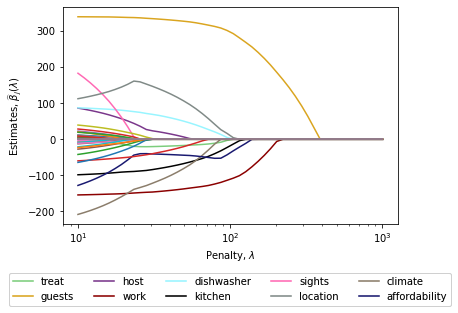

In [19]:
# Create the plot
fig, ax = plt.subplots()

# Plot the LASSO path
lines = ax.plot(lambda_grid, coefs)

# Set colors for the first ten coefficients
for i, line in enumerate(lines[:10]):
    line.set_color(color_codes[i])

ax.set_xscale('log')
plt.xlabel('Penalty, $\lambda$')
plt.ylabel(r'Estimates, $\widehat{\beta}_j(\lambda)$')

XNames = np.array(X.columns)
lgd = ax.legend(XNames[:10], loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=5)  # Adjust bbox_to_anchor
ax.add_artist(lgd)

# Assuming you have defined figpath
figpath = "/Users/bruger/Desktop/Exam/Figures"
filename = "lasso_path.png"

# Combine the path and filename to create the complete file path
full_figpath = f"{figpath}/{filename}"

# Save the figure as a PNG image with specified DPI
fig.savefig(full_figpath, bbox_inches='tight', dpi=300)

plt.show()

# Simple OLS

In [20]:
column_list.remove('price') # dependent variable
column_list.remove('treat') # treatment variable (Swift-concert)

In [21]:
zs = column_list
ds = ['treat']
xs = ds + zs

# avoiding missings
all_vars = ['price'] + xs
I = dat[all_vars].notnull().all(1)

# extract data
X = dat.loc[I, xs].values
Z = dat.loc[I, zs].values
D = dat.loc[I, ds].values
y = dat.loc[I,'price'].values.reshape((-1,1)) 

# check the rank condition
K = X.shape[1]
assert np.linalg.matrix_rank(X) == X.shape[1], f'X does not have full rank'

In [22]:
# OLS: No controls
cD = np.concatenate((np.ones_like(D),D),axis = 1)

betahat = np.linalg.inv(cD.T @ cD) @ cD.T @ y
SSR_none = (y - cD@betahat).T@(y - cD@betahat)

sigma2 = (np.array(SSR_none/(cD.shape[0] - cD.shape[1])))
cov = sigma2*la.inv(cD.T@cD)
se_none = np.sqrt(cov.diagonal()).reshape(-1, 1)

OLS_none = betahat[1]

OLS_CI = OLS_none + norm.ppf(0.975)*np.array([-se_none[1].item(),se_none[1].item()])

# Adding interaction terms

In [23]:
interactions = PolynomialFeatures(interaction_only=True, include_bias = False)
Z_int = interactions.fit_transform(Z)   # Creating control variables with interaction terms
int_names = interactions.get_feature_names_out(zs)

i_idx = []      # defining list to seperate index of variables and interaction terms with variance. 
                # the looping as below is bad code, as it could be written as a one-liner

for i in range(Z_int.shape[1]):
    if np.std(Z_int[:,i]) != 0:
        i_idx.append(i)

Z_int = Z_int[:,i_idx]      # dropping interaction terms with out variance
idx_ = int_names[i_idx]     # dropping variable names of interaction terms without variance
X_int = np.concatenate((D,Z_int),axis = 1)          # Creating all variables with interaction terms

In [24]:
y = dat.loc[I, 'price'] 
X = dat.loc[I, xs].values
D = D.flatten()
len_some = len(X)
contr_some = len(xs) - 1

betahat = np.linalg.inv(X.T @ X) @ X.T @ y

SSR_some = (y - X@betahat).T@(y - X@betahat)

sigma2 = (np.array(SSR_some/(X.shape[0] - X.shape[1])))
cov = sigma2*la.inv(X.T@X)
se_some = np.sqrt(cov.diagonal()).reshape(-1, 1)

OLS_some = betahat[1]
OLS_CI = OLS_some + norm.ppf(0.975)*np.array([-se_some[1].item(),se_some[1].item()])

# Data setup

In [25]:
# Standardize variables for LASSO 
def standardize(X):
    X_mean = np.mean(X,axis=0)
    X_std = np.std(X,axis=0)
    X_stan = (X-X_mean)/X_std
    return X_stan

X_stan = standardize(X)
Z_stan = standardize(Z)
Z_int_stan = standardize(Z_int)
X_int_stan = standardize(X_int)
D_stan = standardize(D)

# Defining penalty term

In [26]:
def CV(X_tilde, y, max_iter=5000, tol=1e-5):
    fit_cv = LassoCV(cv=5, max_iter=max_iter, tol=tol).fit(X_tilde, y)
    penalty_CV = fit_cv.alpha_
    
    return penalty_CV

def BRT(X_tilde,y):
    (N,p) = X_tilde.shape
    sigma = np.std(y)
    c = 1.1
    alpha = 0.05

    penalty_BRT = (sigma * c)/np.sqrt(N)*norm.ppf(1-alpha/(2*p))

    return penalty_BRT

def BCCH(X_tilde,y):
    (N,p) = X_tilde.shape
    c = 1.1 
    alpha = 0.05
    yXscale = (np.max((X_tilde.T ** 2) @ ((y-np.mean(y)) ** 2) / N)) ** 0.5
    lambda_pilot = c*norm.ppf(1-alpha/(2*p))*yXscale/np.sqrt(N)

    # Pilot estimates
    coef_pilot = Lasso(alpha=lambda_pilot).fit(X_tilde,y).coef_
    coef_intercept = Lasso(alpha=lambda_pilot).fit(X_tilde,y).intercept_
    pred = (coef_intercept + X_tilde@coef_pilot)
    pred = Lasso(alpha=lambda_pilot).fit(X_tilde,y).predict(X_tilde)

    # Updated penalty
    res = y - pred
    assert res.ndim == 1        # check residuals only have one dimension
    resXscale = (np.max((X_tilde.T ** 2) @ (res ** 2) / N)) ** 0.5
    lambda_bcch = c*norm.ppf(1-alpha/(2*p))*resXscale/np.sqrt(N)

    return lambda_bcch

# Post Double Lasso

In [27]:
penalty_yx = CV(X_stan, y, max_iter=1000000) 
penalty_BRTyx = BRT(X_stan,y)
penalty_BCCHyx = BCCH(X_stan,y)
penalty_yx_1 = CV(X_int_stan, y, max_iter=100000)  
penalty_BRTyx_1 = BRT(X_int_stan,y)
penalty_BCCHyx_1 = BCCH(X_int_stan,y)

/Users/bruger/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 97078.08739995956, tolerance: 55334.66135086092
  model = cd_fast.enet_coordinate_descent_gram(
/Users/bruger/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 109881.39109611511, tolerance: 55334.66135086092
  model = cd_fast.enet_coordinate_descent_gram(


In [ ]:
# Calculating penalty terms for Swift-dummy
penalty_dz = CV(Z_stan,D,max_iter=1000000)
penalty_BRTdz = BRT(Z_stan,D)
penalty_BCCHdz = BCCH(Z_stan,D)
penalty_dz_1 = CV(Z_int_stan,D,max_iter=1000000)
penalty_BRTdz_1 = BRT(Z_int_stan,D)
penalty_BCCHdz_1 = BCCH(Z_int_stan,D)

In [ ]:
fit_dz = Lasso(alpha=penalty_dz).fit(Z_stan,D) 
fit_dz_1 = Lasso(alpha=penalty_dz_1).fit(Z_int_stan,D) 

# Save residuals
resdz = D - fit_dz.predict(Z_stan)
resdz_1 = D - fit_dz_1.predict(Z_int_stan)

# Lasso on price
fit_yx = Lasso(alpha=penalty_yx).fit(X_stan,y) 
fit_yx_1 = Lasso(alpha=penalty_yx_1).fit(X_int_stan,y) 

# Lasso coefficients
coefs = fit_yx.coef_
coefs_1 = fit_yx_1.coef_

# save residuals
resyxz = y-fit_yx.predict(X_stan) + D_stan*coefs[0]
resyxz_1 = y-fit_yx_1.predict(X_int_stan) + D_stan*coefs_1[0]

In [ ]:
# Lasso on Taylor Dummy
fit_BRTdz = Lasso(alpha=penalty_BRTdz).fit(Z_stan,D) 
fit_BCCHdz = Lasso(alpha=penalty_BCCHdz).fit(Z_stan,D)
fit_BRTdz_1 = Lasso(alpha=penalty_BRTdz_1).fit(Z_int_stan,D) 
fit_BCCHdz_1 = Lasso(alpha=penalty_BCCHdz_1).fit(Z_int_stan,D)

# Save residuals
resdz_BRT = D - fit_BRTdz.predict(Z_stan)
resdz_BCCH = D - fit_BCCHdz.predict(Z_stan)
resdz_BRT_1 = D - fit_BRTdz_1.predict(Z_int_stan)
resdz_BCCH_1 = D - fit_BCCHdz_1.predict(Z_int_stan)

# Lasso on price
fit_BRTyx = Lasso(alpha=penalty_BRTyx).fit(X_stan,y) 
fit_BCCHyx = Lasso(alpha=penalty_BCCHyx).fit(X_stan,y) 
fit_BRTyx_1 = Lasso(alpha=penalty_BRTyx_1).fit(X_int_stan,y) 
fit_BCCHyx_1 = Lasso(alpha=penalty_BCCHyx_1).fit(X_int_stan,y) 

# Lasso coefficients
coefs_BRT = fit_BRTyx.coef_
coefs_BCCH = fit_BCCHyx.coef_
coefs_BRT_1 = fit_BRTyx_1.coef_
coefs_BCCH_1 = fit_BCCHyx_1.coef_

# save residuals
resyxz_BRT = y-fit_BRTyx.predict(X_stan) + D_stan*coefs_BRT[0]
resyxz_BCCH = y-fit_BCCHyx.predict(X_stan) + D_stan*coefs_BCCH[0]
resyxz_BRT_1 = y-fit_BRTyx_1.predict(X_int_stan) + D_stan*coefs_BRT_1[0]
resyxz_BCCH_1 = y-fit_BCCHyx_1.predict(X_int_stan) + D_stan*coefs_BCCH_1[0]

In [ ]:
def PDL_ols(resdz,resyxz,d):
    denom = np.sum(resdz*d)
    num = np.sum(resdz*resyxz)
    return num/denom

def PDL_CI(resdz,resyzz):
    # Variance

    N = resyzz.shape[0]
    num = np.sum(resdz**2*resyzz**2)/N
    denom = (np.sum(resdz**2)/N)**2
    sigma2_PDL = num/denom

    # Confidence interval
    q=norm.ppf(1-0.025)
    se_PDL = np.sqrt(sigma2_PDL/N)      # calculating standard error as the squareroot of the mean variance
    CI_PDL=(((PDL-q*se_PDL).round(2),(PDL+q*se_PDL).round(2)))

    return se_PDL, CI_PDL

# Save residuals
resyzz = y - fit_yx.predict(X_stan)
resyzz_BRT = y - fit_BRTyx.predict(X_stan)
resyzz_BCCH = y - fit_BCCHyx.predict(X_stan)
resyzz_1 = y - fit_yx_1.predict(X_int_stan)
resyzz_BRT_1 = y - fit_BRTyx_1.predict(X_int_stan)
resyzz_BCCH_1 = y - fit_BCCHyx_1.predict(X_int_stan)

# Estimating Post Double Lasso
PDL = PDL_ols(resdz,resyxz,D)
PDL_BRT = PDL_ols(resdz_BRT,resyxz_BRT,D)
PDL_BCCH = PDL_ols(resdz_BCCH, resyxz_BCCH, D)
PDL_1 = PDL_ols(resdz_1,resyxz_1,D)
PDL_BRT_1 = PDL_ols(resdz_BRT_1,resyxz_BRT_1,D)
PDL_BCCH_1 = PDL_ols(resdz_BCCH_1, resyxz_BCCH_1, D)

# estimating standard errors and confidence interval for Post Double Lasso
se_PDL, CI_PDL = PDL_CI(resdz, resyzz)
se_PDL_BRT, CI_PDL_BRT = PDL_CI(resdz_BRT, resyzz_BRT)
se_PDL_BCCH, CI_PDL_BCCH = PDL_CI(resdz_BCCH, resyzz_BCCH)
se_PDL_1, CI_PDL_1 = PDL_CI(resdz_1, resyzz_1)
se_PDL_BRT_1, CI_PDL_BRT_1 = PDL_CI(resdz_BRT_1, resyzz_BRT_1)
se_PDL_BCCH_1, CI_PDL_BCCH_1 = PDL_CI(resdz_BCCH_1, resyzz_BCCH_1)

# Results

In [ ]:
# Estimates
estimates = np.array([OLS_none[0], OLS_some, PDL, PDL_1, PDL_BCCH, PDL_BCCH_1]).round(1)
label_over_column = ['(1)','(2)','(3)','(4)','(5)','(6)']
label_column = np.array(['OLS', 'OLS', 'PDL (CV)', 'PDL (CV)', 'PDL (BCCH)', 'PDL (BCCH)'])
label_row = ['' ,'Swift-effect', 'se', 'No controls','No obs','$\lambda^{dz}$','$\lambda^{yx}$','t-statistic']
se = np.array([se_none[1].item(),se_some[1].item(),se_PDL, se_PDL_1,se_PDL_BCCH, se_PDL_BCCH_1]).round(1)
no_controls = np.array([0, contr_some, len(zs), Z_int_stan.shape[1], len(zs), Z_int_stan.shape[1]])
no_obs = np.array([len(y), len(y), len(y), len(y), len(y), len(y)])

pens_dz = np.array(['','', penalty_dz.round(4), penalty_dz_1.round(4), penalty_BCCHdz.round(4),penalty_BCCHdz_1.round(4)])
pens_yx = np.array(['','', penalty_yx.round(1), penalty_yx_1.round(1), penalty_BCCHyx.round(1), penalty_BCCHyx_1.round(1)])

t_statistic = (estimates/se).round(2)    

data = np.row_stack((label_column ,estimates, se, no_controls,no_obs, pens_dz, pens_yx,t_statistic))

df = pd.DataFrame(data = data, index = label_row, columns = label_over_column)

print(df.to_latex(escape = False))

## Table with estimates of control variables

In [ ]:
# LASSO estimates - CV with out interactions
df_tab = pd.DataFrame(data = np.row_stack((fit_dz.coef_,fit_yx.coef_[1:])).T, index = zs,columns = ['dz','yx']) # collecting all estimates for both stages, exluding air bnb prices
print(df_tab.loc[~(df_tab==0).all(axis=1)].round(4).to_latex(escape=False)) # removing all estimates equal to zero

In [ ]:
# LASSO estimates - CV with interaction terms
df_tab_int = pd.DataFrame(data = np.row_stack((fit_dz_1.coef_,fit_yx_1.coef_[1:])).T, index = idx_,columns = ['dz','yx']) # using idx_, as this variable is control variable names, adjusted for those delted due to no variance
print(df_tab_int.loc[~(df_tab_int==0).all(axis=1)].round(4).to_latex(escape=False))

In [ ]:
# LASSO estimates - BCCH without interaction terms
df_tab_int = pd.DataFrame(data = np.row_stack((fit_BCCHdz.coef_,fit_BCCHyx.coef_[1:])).T, index = zs,columns = ['dz','yx']) # using idx_, as this variable is control variable names, adjusted for those delted due to no variance
print(df_tab_int.loc[~(df_tab_int==0).all(axis=1)].round(4).to_latex(escape=False))

In [ ]:
# LASSO estimates - BCCH with interaction terms
df_tab_int = pd.DataFrame(data = np.row_stack((fit_BCCHdz_1.coef_,fit_BCCHyx_1.coef_[1:])).T, index = idx_,columns = ['dz','yx'])
# no non-zero control variables
print(df_tab_int.loc[~(df_tab_int==0).all(axis=1)].round(4).to_latex(escape=False))